In [1]:
import pandas as pd
import numpy as np

import json
import functools as ft
import itertools as it
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
louv = pd.read_csv('../results/weighted/louvain_clusters.txt', index_col=0, header=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../results/weighted/louvain_small_clusters.txt', index_col=0, header=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [21]:
enst_to_hgnc = pd.read_csv('../data/ref/ensdb.hsapiens.v86.mapping.csv', index_col=0)['name'].to_dict()
next(iter(enst_to_hgnc.items()))

('ENST00000456328', 'DDX11L1')

In [61]:
salmon_dir = '../data/exper/salmon_alignment/'
quant_filename = '/quant.sf'

trametinib_replicate_folders = {'rep_1':'SUM159_100nM_trametinib_24h_replicate1.fastq.gz', 
                            'rep_2':'SUM159_100nM_trametinib_24h_replicate2.fastq.gz',
                            'rep_3':'SUM159_100nM_trametinib_24h_replicate3.fastq.gz'}

dmso_replicate_folders = {'rep_1':'SUM159_DMSO_24h_replicate1.fastq.gz',
                          'rep_2':'SUM159_DMSO_24h_replicate2.fastq.gz',
                          'rep_3':'SUM159_DMSO_24h_replicate3.fastq.gz'}

trametinib_data = {}
dmso_data = {}

In [64]:
# read in trametinib data
for rep in trametinib_replicate_folders.keys():
    # read in quant sf file for the replicate
    local_dat = pd.read_csv(salmon_dir + trametinib_replicate_folders[rep] + quant_filename, sep='\t')
    
    # map to hgnc
    local_dat['hgnc'] = local_dat['Name'].apply(lambda x: enst_to_hgnc[x.split('.')[0]] if x.split('.')[0] in enst_to_hgnc.keys() else None)
    
    local_dat = local_dat.groupby('hgnc').agg({'Length':np.sum, 'EffectiveLength':np.sum, 'TPM':np.sum, 'NumReads':np.sum})
    
    trametinib_data[rep] = copy(local_dat)    
    
    
# read in dmso data
for rep in dmso_replicate_folders.keys():
    # read in quant sf file for the replicate
    local_dat = pd.read_csv(salmon_dir + dmso_replicate_folders[rep] + quant_filename, sep='\t')
    
    # map to hgnc
    local_dat['hgnc'] = local_dat['Name'].apply(lambda x: enst_to_hgnc[x.split('.')[0]] if x.split('.')[0] in enst_to_hgnc.keys() else None)
    
    local_dat = local_dat.groupby('hgnc').agg({'Length':np.sum, 'EffectiveLength':np.sum, 'TPM':np.sum, 'NumReads':np.sum})
    
    dmso_data[rep] = copy(local_dat)

In [70]:
trametinib_tpm = (trametinib_data['rep_1'] + trametinib_data['rep_2'] + trametinib_data['rep_3'])['TPM']/3
dmso_tpm = (dmso_data['rep_1'] + dmso_data['rep_2'] + dmso_data['rep_3'])['TPM']/3

In [73]:
louv_trametinib = copy(louv.merge(trametinib_tpm, how='left', left_index=True, right_index=True))
print('Number of missing kinases:', np.sum(np.isnan(louv_trametinib.TPM)))
louv_trametinib.head()

Number of missing kinases: 5


,cluster_super,cluster_sub,fold_change,TPM
names,,,,
MST1R,3,11,0.493,0.311303
YES1,3,11,-0.210,17.977394
TYRO3,3,11,0.184,41.031141
FGR,3,11,0.000,0.412264
SRC,3,11,0.463,17.007783


In [74]:
from copy import copy
louv_dmso = copy(louv.merge(dmso_tpm, how='left', left_index=True, right_index=True))
print('Number of missing kinases:', np.sum(np.isnan(louv_dmso.TPM)))
louv_dmso.head()

Number of missing kinases: 5


,cluster_super,cluster_sub,fold_change,TPM
names,,,,
MST1R,3,11,0.493,0.265201
YES1,3,11,-0.210,23.820136
TYRO3,3,11,0.184,24.760104
FGR,3,11,0.000,0.010444
SRC,3,11,0.463,11.261300


In [75]:
fold_change = np.round(np.log2(list(map(lambda x: x[0]/x[1] if x[0] != 0 and x[1] != 0 else 1 if x[0] is not np.nan and x[1] is not np.nan else np.nan, zip(louv_trametinib.TPM, louv_dmso.TPM)))), 3)
louv['fold_change'] = fold_change
louv.head()

,cluster_super,cluster_sub,fold_change
names,,,
MST1R,3,11,0.231
YES1,3,11,-0.406
TYRO3,3,11,0.729
FGR,3,11,5.303
SRC,3,11,0.595


In [76]:
louv.fold_change[louv.fold_change.isna()]

names
MAP3K20   NaN
SGK196    NaN
HASPIN    NaN
MAP3K21   NaN
PRAG1     NaN
Name: fold_change, dtype: float64

In [77]:
louv_fold = louv[louv.columns[-1:]]
louv_fold.to_csv('../viz/js/circle_pack_viz/dist/viz_fold.csv')

In [79]:
print(min(louv.fold_change) ,max(louv.fold_change))

-4.293 6.19


/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


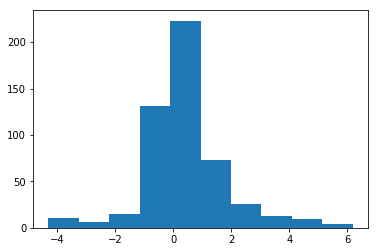

In [78]:
plt.hist(list(filter(lambda x: x is not np.nan, louv.fold_change)))
plt.show()